<a href="https://colab.research.google.com/github/MinahilRaza/DataScience_Playground/blob/main/notebooks/SocialNetworkAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 3: Twitter Network Analysis



**Note**

Please run the notebook in a Google Colab environment instead of your default conda environment. The notebook uses Plotly graphs. The rendering option has been set to Google Colab. It might not render on your local environment

Import the necessary libraries

In [ ]:
import tweepy,json
from google.colab import files
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

#for network creation
import networkx as nx

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



## Twitter API Authentication Credentials

In [ ]:
#@title Enter Your Twitter API Credentials
access_token="" #@param {type:"string"}
access_token_secret="" #@param {type:"string"}
consumer_key="" #@param {type:"string"}
consumer_secret="" #@param {type:"string"}


In [ ]:
auth= tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
# Create API object
api = tweepy.API(auth, wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

In [ ]:
# top ten countries with most twitter users
countries = ['USA', 'Japan', 'India', 'United Kingdom', 'Brazil',
             'Indonesia', 'Turkey', 'Saudi Arabia','Mexico','Thailand']
#get place id for the countries
place_ids = []
for country in countries:
  places = api.geo_search(query=country, granularity="country")
  place_id = places[0].id
  place_ids.append(place_id)

In [ ]:
all_tweets = []
max_tweets = 1000
for place_id in place_ids:
  query = "place:"+ str(place_id)
  tweets = [status for status in tweepy.Cursor(api.search, q=query, tweet_mode = "extended", lang = 'en').items(max_tweets)]
  all_tweets.append(tweets)

In [ ]:
def store_tweets(alltweets, country, file='tweets.json'):
 
  # a list of all formatted tweets
  tweet_list=[]

  for tweet in alltweets:
		# a dict to contain information about single tweet
    tweet_information=dict()
		# text of tweet
    tweet_information['text']=tweet.full_text
		# date and time at which tweet was created
    tweet_information['created_at']=tweet.created_at.strftime("%Y-%m-%d %H:%M:%S")
		# id of this tweet
    tweet_information['id_str']=tweet.id_str
    # source of this tweet
    tweet_information['source']=tweet.source
    # source url of this tweet
    tweet_information['source_url']=tweet.source_url
    # name of place of this tweet
    tweet_information['place'] = tweet.place.name if tweet.place else "Undefined place"
    # name of the country
    tweet_information['country'] = country
		# retweet?
    tweet_information['is_retweet'] = tweet.retweeted
    # retweet count
    tweet_information['retweet_count'] = tweet.retweet_count
		# favourites count
    tweet_information['favorite_count'] = tweet.favorite_count
		# screen name of the user to which it was replied (is Nullable)
    tweet_information['in_reply_to_screen_name'] = tweet.in_reply_to_screen_name
    # user id of the user to which it was replied (is Nullable)
    tweet_information['in_reply_to_user_id'] = tweet.in_reply_to_user_id
    # user id str of the user to which it was replied (is Nullable)
    tweet_information['in_reply_to_user_id_str'] = tweet.in_reply_to_user_id_str
    # status id of the tweet to which it was replied (is Nullable)
    tweet_information['in_reply_to_status_id'] = tweet.in_reply_to_status_id
    # retweet info of the tweet to which it was replied (is Nullable)
    try:
          tweet_information['original_tweeter_name'] = tweet.retweeted_status.user.screen_name
          tweet_information['original_tweeter_id'] = tweet.retweeted_status.user.id
          tweet_information['original_tweet_id'] = tweet.retweeted_status.id
    except AttributeError:
          original_tweeter = None
          original_tweeter_id = None
          original_tweet_id = None
    
    
    # user information in user dictionary
    user_dictionary=tweet._json['user']
		# no of followers of the user
    tweet_information['followers_count'] = user_dictionary['followers_count']
		# screen name of the person who tweeted this
    tweet_information['screen_name'] = user_dictionary['screen_name']
		# hashtags used
    tweet_information['entities'] = tweet.entities
    # original lang
    tweet_information['lang'] = tweet.lang

		# add this tweet to the tweet_list
    tweet_list.append(tweet_information)


	# open file desc to output file with write permissions
  file_des=open(file,'w')

	# dump tweets to the file
  json.dump(tweet_list,file_des,indent=4,sort_keys=True)

	# close the file_des
  file_des.close()


In [ ]:
for n,country in enumerate(countries):
  print(country)
  store_tweets(all_tweets[n],country, country+'.json')

In [ ]:
dfs = [] # an empty list to store the data frames
for country in countries:
    file= country+'.json'
    data = pd.read_json(file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
df.to_csv('tweetsv2.csv', index= False)

## Data Preprocessing
First, let's clean this data. For the sentiment analysis, I am interested in the tweet text. Therefore, any nulls in this column will be dropped.

### Missing Values

In [ ]:
# Upload the dataset

uploaded = files.upload()

Saving tweets_Minahil.csv to tweets_Minahil.csv


In [ ]:
file_name = list(uploaded.keys())[0]
try:
    df = pd.read_csv(file_name, lineterminator='\n')
    print("Data loaded successfully.")
except:
    print('Please re-upload the correct file.')

Data loaded successfully.


In [ ]:
# Correct the datatype of the entities column. It does not get loaded correctly 
# without additional pre processing through the ast package
import ast
try:
  df['entities'] = df['entities'].apply(lambda x: ast.literal_eval(x))
except:
  print('The entities column is already in the right format')

In [ ]:
# print information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9719 entries, 0 to 9718
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  9719 non-null   object 
 1   created_at               9719 non-null   object 
 2   entities                 9719 non-null   object 
 3   favorite_count           9719 non-null   int64  
 4   followers_count          9719 non-null   int64  
 5   id_str                   9719 non-null   int64  
 6   in_reply_to_screen_name  3937 non-null   object 
 7   in_reply_to_status_id    3760 non-null   float64
 8   in_reply_to_user_id      3937 non-null   float64
 9   in_reply_to_user_id_str  3937 non-null   float64
 10  is_retweet               9719 non-null   bool   
 11  lang                     9719 non-null   object 
 12  place                    9719 non-null   object 
 13  retweet_count            9719 non-null   int64  
 14  screen_name             

In [ ]:
#Drop any NULLs
df = df.dropna(subset=['text'])

In [ ]:
# Human Development Index
HDI = {'USA': 0.926, 'Japan':0.919, 'India':0.645, 'United Kingdom':0.932, 
       'Brazil': 0.765, 'Indonesia': 0.718, 'Turkey':0.820, 'Saudi Arabia':0.854,
       'Mexico':0.779,'Thailand':0.777}

# GDP (nominal) per capita
GDP = {'USA': 68309, 'Japan':42928, 'India':2191, 'United Kingdom':46344, 
       'Brazil': 7011, 'Indonesia': 4256, 'Turkey':9327, 'Saudi Arabia':22700,
       'Mexico': 9246,'Thailand':7702}

# Literacy rate
LR = {'USA': 79, 'Japan':99, 'India':75.4, 'United Kingdom':99, 
       'Brazil': 92.0, 'Indonesia': 95.4, 'Turkey':96.2, 'Saudi Arabia':94.4,
       'Mexico': 94.9 ,'Thailand':92.9}



 ## Exploratory Data Analysis
 Let's explore the different columns in our dataset for some interesting insights. Since, we are looking at the data across different countries, I have plotted the data of different countries side by side as well for better comparison


 Let's have a look at all the column names first.

In [ ]:
df.columns

Index(['country', 'created_at', 'entities', 'favorite_count',
       'followers_count', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_retweet', 'lang', 'place',
       'retweet_count', 'screen_name', 'source', 'source_url', 'text'],
      dtype='object')

I gave an upper limit of 1000 for each country. Let's see how many tweets from each country are present in the dataset

After data collecting and cleaning every country apart from UK has 1000 tweets in the dataset 

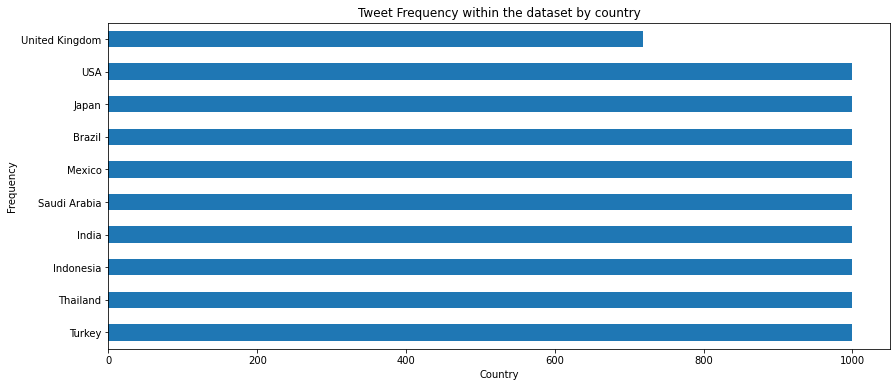

In [ ]:
plt.figure(figsize=(14,6))
temp = df['country'].value_counts().plot(kind= 'barh');
plt.title('Tweet Frequency within the dataset by country');
plt.xlabel('Country');
plt.ylabel('Frequency');

Within these countries, data has been collected from many different places. Let's make a treemap to analyze the distribution of tweets across different places within each country.

For the sake of better visualization, I have excluded places with tweets less then 10. The treemap shows which cities/states within a particular country had the most tweet volume. 

**Play Around With the Plot**


The cool part about the plotly visualization is that it is interactive. For example, if you click on USA, it expands the treemap and you can look at that data alone. Moreover, with plotly charts, information can be displayed on tooltips.

In [ ]:
df1 = df.groupby(['country'])['place'].value_counts()
df1 = df1[df1>10]
parents = []
labels = []

for i in np.sort(df.country.unique()):
  parents.append("")
  labels.append(i)
for i in df1.index.tolist():
  parents.append(i[0])
  labels.append(i[1])

a = list(df1.groupby('country').sum().values)
b = list(df1.values)
values = a+b

fig = go.Figure(go.Treemap(
    labels = labels,
    parents = parents,
    values = values
))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25), 
                  title="Treemap showing Tweet Frequency across cities and countries")
fig.show(renderer='colab')

Let's have a look at the source column and see which platform/source was most common amongst the twitter users of these countries

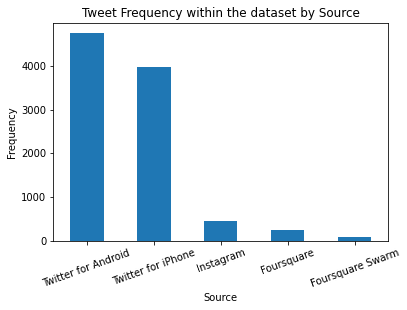

In [ ]:
df.source.value_counts()[:5].plot(kind= 'bar');
plt.title('Tweet Frequency within the dataset by Source');
plt.xlabel('Source');
plt.ylabel('Frequency')
plt.xticks(rotation = 20);

Android and iPhone are the most common platforms. Let's see the ratio of Android and iPhone users in each country.

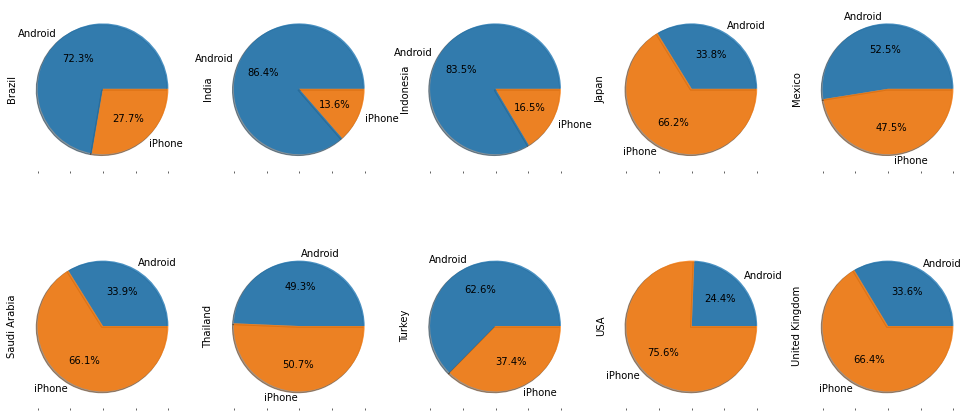

In [ ]:
dfu = df[(df.source=='Twitter for Android') | 
         (df.source== 'Twitter for iPhone')].replace(to_replace ="Twitter for Android",
                 value ="Android").replace(to_replace ="Twitter for iPhone",
                 value ="iPhone").groupby(['source']).country.value_counts().unstack()
axes = dfu.plot(kind='pie', subplots = True, layout=(2,5) ,figsize=(17, 8), legend = False,
             rot=20, autopct='%1.1f%%',shadow=True, wedgeprops={'alpha':0.8})

In [ ]:
#interesting GDP is actually related to this ratio. iphone/ android ratio and scatter plot against gdp
r1 = dfu.apply(lambda x: x['iPhone']/x['Android']).to_dict()
df_s = pd.DataFrame([GDP, HDI, LR, r1])
df_s.index = ['Gross Domestic Product', 'Human Development Index', 'Literacy Rate', 'iPhone to Android use ratio']
df_s = df_s.transpose()

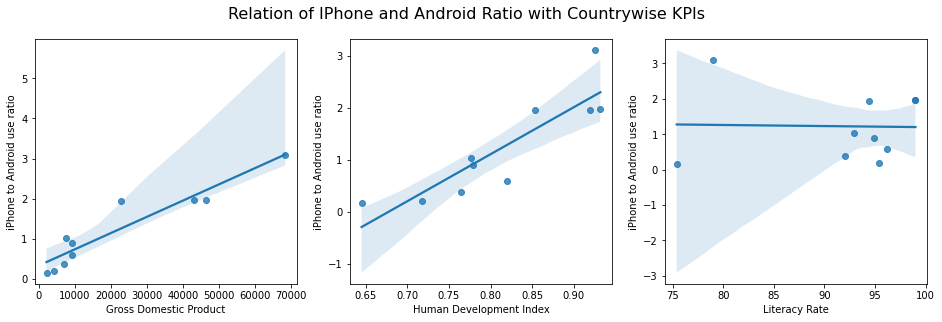

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,4.5))
sns.regplot(ax=axes[0], y=df_s['iPhone to Android use ratio'],x=df_s['Gross Domestic Product']);
sns.regplot(ax=axes[1], y=df_s['iPhone to Android use ratio'],x=df_s['Human Development Index']);
sns.regplot(ax=axes[2], y=df_s['iPhone to Android use ratio'],x=df_s['Literacy Rate']);
fig.suptitle('Relation of IPhone and Android Ratio with Countrywise KPIs', fontsize=16);

**Relationship with Gross Domestic Product**

A positive correlation exists between the GDP and iPhone usage. iPhone market shares are actually more popular in countries with higher GDPs.

**Relationship with Human Development Index**

A positive correlation exists between these two variables

**Relationship with Literacy Rate**

There is no evident relationship between these two variables


Now, let's have a look at the relationship between KPIs and favourite count.

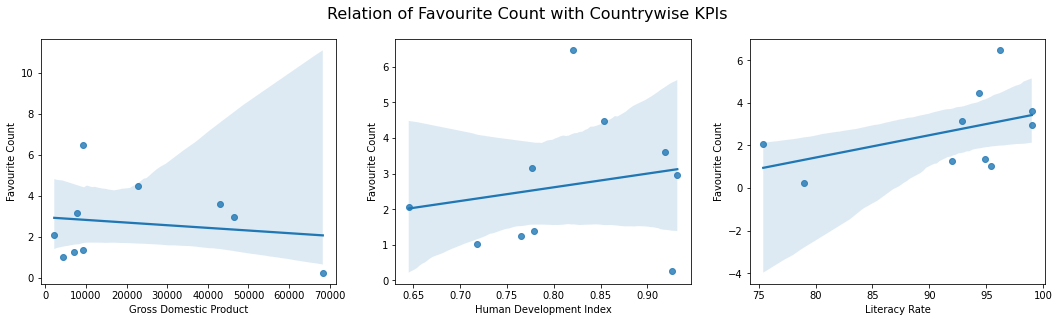

In [ ]:
temp = df.groupby('country').favorite_count.mean().to_dict()
df_s = pd.DataFrame([GDP, HDI, LR, temp])
df_s.index = ['Gross Domestic Product', 'Human Development Index', 'Literacy Rate', 'Favourite Count']
df_s = df_s.transpose()

fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
sns.regplot(ax=axes[0], y=df_s['Favourite Count'],x=df_s['Gross Domestic Product']);
sns.regplot(ax=axes[1], y=df_s['Favourite Count'],x=df_s['Human Development Index']);
sns.regplot(ax=axes[2], y=df_s['Favourite Count'],x=df_s['Literacy Rate']);
fig.suptitle('Relation of Favourite Count with Countrywise KPIs', fontsize=16);

**Relationship with Gross Domestic Product**

A negative correlation exists between the GDP and favourite count. The correlation is very weak to draw any conclusion.

**Relationship with Human Development Index**

A slightly positive correlation exists between these two variables

**Relationship with Literacy Rate**

A positive correlation exists between these two variables. People in countries with a higher literacy rate liked each others' tweets more as compared to less literate  countries

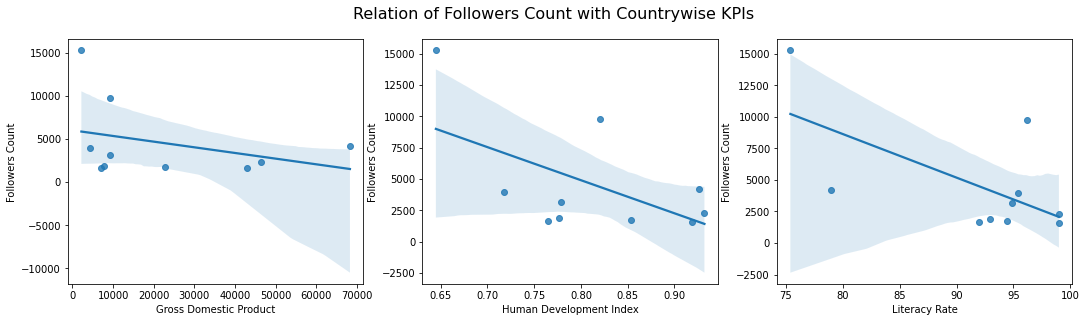

In [ ]:
temp = df.groupby('country').followers_count.mean().to_dict()
df_s = pd.DataFrame([GDP, HDI, LR, temp])
df_s.index = ['Gross Domestic Product', 'Human Development Index', 'Literacy Rate', 'Followers Count']
df_s = df_s.transpose()

fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
sns.regplot(ax=axes[0], y=df_s['Followers Count'],x=df_s['Gross Domestic Product']);
sns.regplot(ax=axes[1], y=df_s['Followers Count'],x=df_s['Human Development Index']);
sns.regplot(ax=axes[2], y=df_s['Followers Count'],x=df_s['Literacy Rate']);
fig.suptitle('Relation of Followers Count with Countrywise KPIs', fontsize=16);

**Relationship with Gross Domestic Product**

A negative correlation exists between the GDP and favourite count. The correlation is very weak to draw any conclusion.

**Relationship with Human Development Index**

Anegative correlation exists between these two variables

**Relationship with Literacy Rate**

A negative correlation exists between these two variables. 

## Twitter Sentiment Analysis 

In [ ]:
sia = SentimentIntensityAnalyzer() # pretrained sentiment analyzer
def sentiment(tweet):
  analysis = sia.polarity_scores(tweet)['compound']
  if analysis>0:
    return 'Positive'    
  elif analysis<0:    
    return 'Negative'    
  else:       
    return 'Neutral'
df['sentiment'] = df['text'].apply(lambda x: sentiment(x))

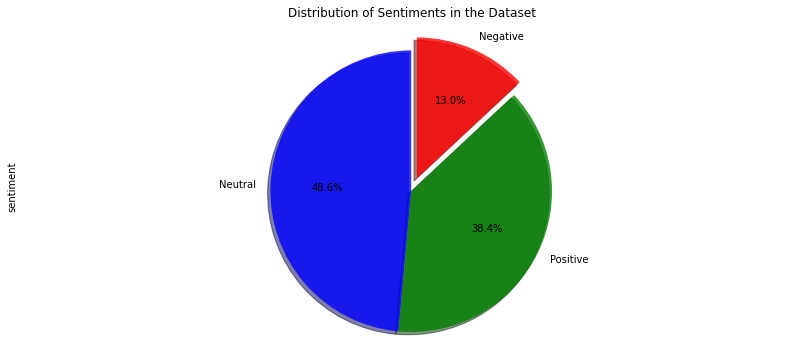

In [ ]:
plt.figure(figsize=(14,6));
temp = df['sentiment'].value_counts()
explode = (0, 0, 0.1)
temp.plot(kind = 'pie', explode=explode, colors="bgr", autopct='%1.1f%%',
          shadow=True, startangle=90, wedgeprops={'alpha':0.8},
          title = "Distribution of Sentiments in the Dataset");
plt.axis('equal');

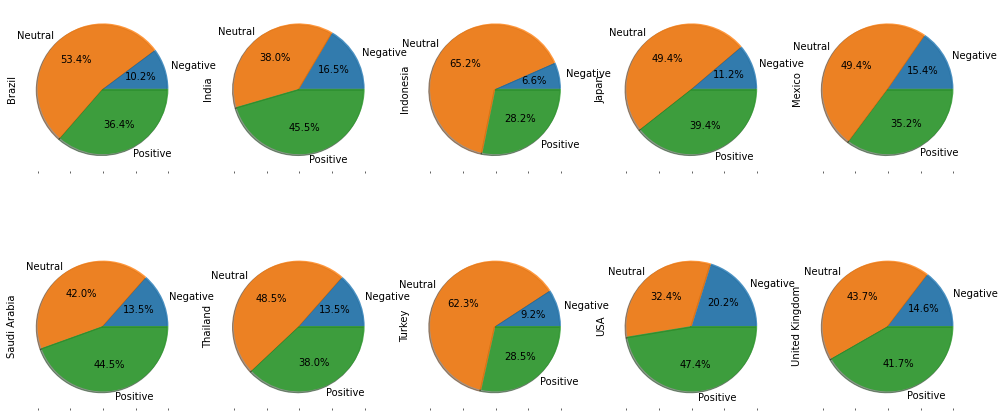

In [ ]:
dfu = df.groupby(['sentiment']).country.value_counts().unstack()
axes = dfu.plot(kind='pie', subplots = True, layout=(2,5) ,figsize=(17, 8), legend = False,
             rot=20, autopct='%1.1f%%',shadow=True, wedgeprops={'alpha':0.8})

In [ ]:
# country wise tree map may be, display perentage on treemap. Or a sunburst chart
df1 = df.groupby(['country'])['sentiment'].value_counts()
parents = []
labels = []

for i in np.sort(df.country.unique()):
  parents.append("")
  labels.append(i)
for i in df1.index.tolist():
  parents.append(i[0])
  labels.append(i[1])

a = list(df1.groupby('country').sum().values)
b = list(df1.values)
values = a + b

fig = go.Figure(go.Sunburst(
    labels = labels,
    parents = parents,
    values = values,
    branchvalues="total"
))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25), 
                  title="Treemap showing Tweet Sentiments across countries")
fig.show(renderer='colab')

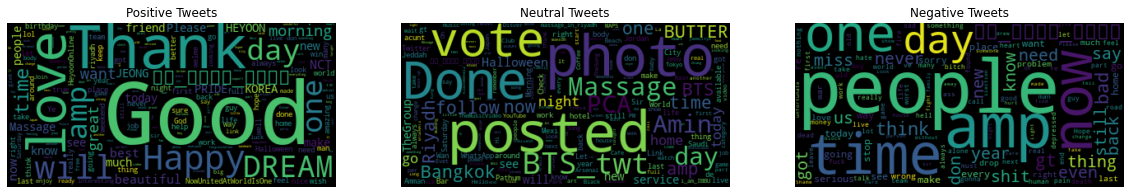

<Figure size 432x288 with 0 Axes>

In [ ]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1,3,figsize=(20, 5))

text = " ".join(cat for cat in df[df.sentiment == 'Positive'].text)
text = text.replace('https', '')
text = text.replace('co', '')
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(text)
axes[0].imshow(word_cloud, interpolation='bilinear');
axes[0].axis("off");
axes[0].title.set_text('Positive Tweets');

text = " ".join(cat for cat in df[df.sentiment == 'Negative'].text)
text = text.replace('https', '')
text = text.replace('co', '').replace('will', '')
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(text)
axes[2].imshow(word_cloud, interpolation='bilinear');
axes[2].axis("off");
axes[2].title.set_text('Negative Tweets');

text = " ".join(cat for cat in df[df.sentiment == 'Neutral'].text)
text = text.replace('https', '')
text = text.replace('co', '')
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(text)
axes[1].imshow(word_cloud, interpolation='bilinear');
axes[1].axis("off");
axes[1].title.set_text('Neutral Tweets');

plt.show()
plt.tight_layout();

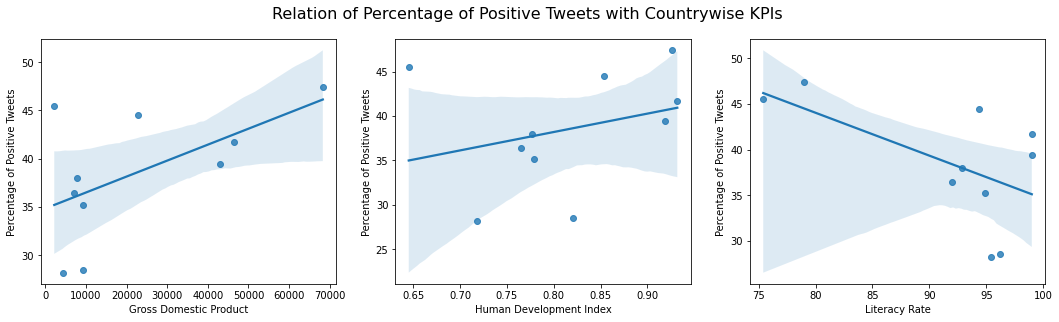

In [ ]:
# Let's calculate positivity ratios and link them to our KPIs for all countries

temp1 = df[df.sentiment == 'Positive'].groupby(['country']).sentiment.count()/ df.groupby(['country']).sentiment.count()
temp1.to_dict()

temp2 = df[df.sentiment == 'Positive'].groupby(['country']).sentiment.count()/ df[df.sentiment == 'Negative'].groupby(['country']).sentiment.count()
temp2.to_dict()

temp3 = df[df.sentiment == 'Negative'].groupby(['country']).sentiment.count()/ df.groupby(['country']).sentiment.count()
temp3.to_dict()

df_s = pd.DataFrame([GDP, HDI, LR, temp1, temp2, temp3])
df_s.index = ['Gross Domestic Product', 'Human Development Index','Literacy Rate', 
              'Percentage of Positive Tweets', 'Positive to Negative Tweets Ratio',
              'Percentage of Negative Tweets']
df_s = df_s.transpose()

fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
sns.regplot(ax=axes[0], y=df_s['Percentage of Positive Tweets']*100,x=df_s['Gross Domestic Product']);
sns.regplot(ax=axes[1], y=df_s['Percentage of Positive Tweets']*100,x=df_s['Human Development Index']);
sns.regplot(ax=axes[2], y=df_s['Percentage of Positive Tweets']*100,x=df_s['Literacy Rate']);
fig.suptitle('Relation of Percentage of Positive Tweets with Countrywise KPIs', fontsize=16);


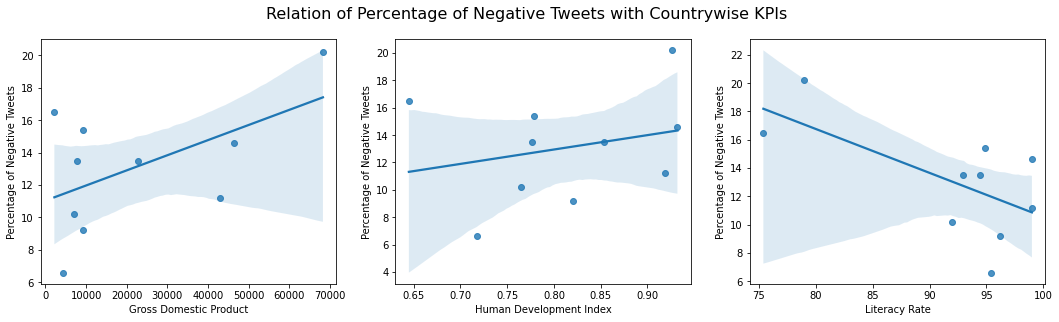

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
sns.regplot(ax=axes[0], y=df_s['Percentage of Negative Tweets']*100,x=df_s['Gross Domestic Product']);
sns.regplot(ax=axes[1], y=df_s['Percentage of Negative Tweets']*100,x=df_s['Human Development Index']);
sns.regplot(ax=axes[2], y=df_s['Percentage of Negative Tweets']*100,x=df_s['Literacy Rate']);
fig.suptitle('Relation of Percentage of Negative Tweets with Countrywise KPIs', fontsize=16);

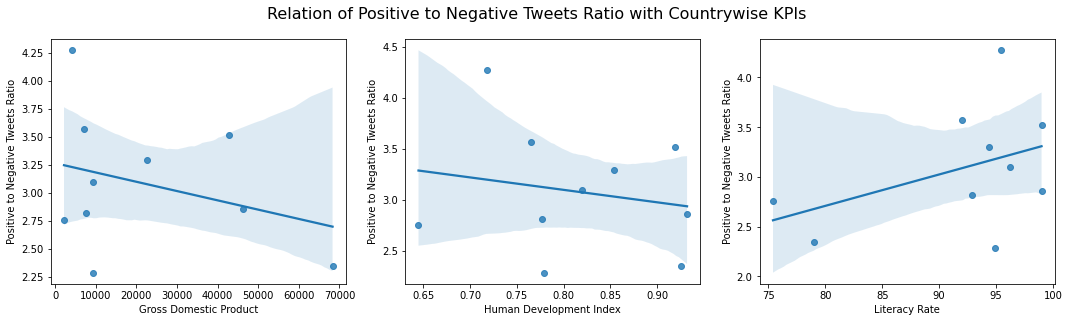

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
sns.regplot(ax=axes[0], y=df_s['Positive to Negative Tweets Ratio'],x=df_s['Gross Domestic Product']);
sns.regplot(ax=axes[1], y=df_s['Positive to Negative Tweets Ratio'],x=df_s['Human Development Index']);
sns.regplot(ax=axes[2], y=df_s['Positive to Negative Tweets Ratio'],x=df_s['Literacy Rate']);
fig.suptitle('Relation of Positive to Negative Tweets Ratio with Countrywise KPIs', fontsize=16);

## Twitter Network Analysis


In [ ]:
# Get the user mentions 
# Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
df1=df
df1["user_mentions_screen_name"] = df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
df1["user_mentions_id"] = df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)



In [ ]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe ,obtain the 'user_id' and 'screen_name'
    user = row["id_str"], row["screen_name"], row["country"]
    # Check for no user id
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    
    # Add all interactions 
    # interactions corresponding to replies
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["id_str"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [ ]:
df1 = df1.where((pd.notnull(df1)), None)

In [ ]:
graph = nx.Graph()
color_dict = {'Positive': 'green', 'Negative':'red', 'Neutral':'blue'}
for index, tweet in df1.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name, user_country = user
    tweet_id = tweet["id_str"]
    tweet_text = tweet["text"]
    tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        color = color_dict[tweet_sent]
        graph.add_edge(user_id, int_id, tweet_id=tweet_id, tweet_sent= tweet_sent, color= color, text =tweet_text)
        

        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name
        graph.nodes[user_id]['country'] = user_country 

In [ ]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 11394 nodes and 8373 edges present in the Graph


In [ ]:
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 73
The minimum degree of the Graph is 1


In [ ]:

print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The average degree of the nodes in the Graph is 1.5
The most frequent degree of the nodes found in the Graph is 1


In [ ]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [ ]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 3696 connected components in the Graph


In [ ]:
largest_subgraph = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=len)
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

There are 75 nodes and 146 edges present in the largest component of the Graph


In [ ]:
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0


In [ ]:
print(f"The diameter of the Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

The diameter of the Graph is 2
The average distance between any two nodes is 1.95


In [ ]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id 1.0634019974901596e+18 has a degree centrality of 0.99 which is the maximum of the Graph
the node with id 1.0634019974901596e+18 has a closeness centrality of 0.99 which is the maximum of the Graph
the node with id 1.0634019974901596e+18 has a betweenness centrality of 0.49 which is the maximum of the Graph


In [ ]:
def make_graph(graph):
  plt.figure(figsize = (20,8))
  edges = graph.edges()
  edge_colors = [graph[u][v]['color'] for u,v in edges]

  node_color = ['black']
  node_country = nx.get_node_attributes(graph,'country');
  for i in node_country:
    if node_country[i]== 'Japan':
      node_color.append('red')
    else:
      node_color.append('blue')
  pos = nx.spring_layout(graph);
  nx.draw(graph, pos, edge_color=edge_colors, font_size=15);
  node_labels = nx.get_node_attributes(graph,'name');
  
  nx.draw_networkx_labels(graph,pos, labels = node_labels);

In [ ]:
# extract subgraphs
sub_graphs = nx.connected_components(graph)
biggest= []
for i, sg in enumerate(sub_graphs):
    sg = graph.subgraph(sg)
    if sg.number_of_nodes()> 15:
      biggest.append(sg)

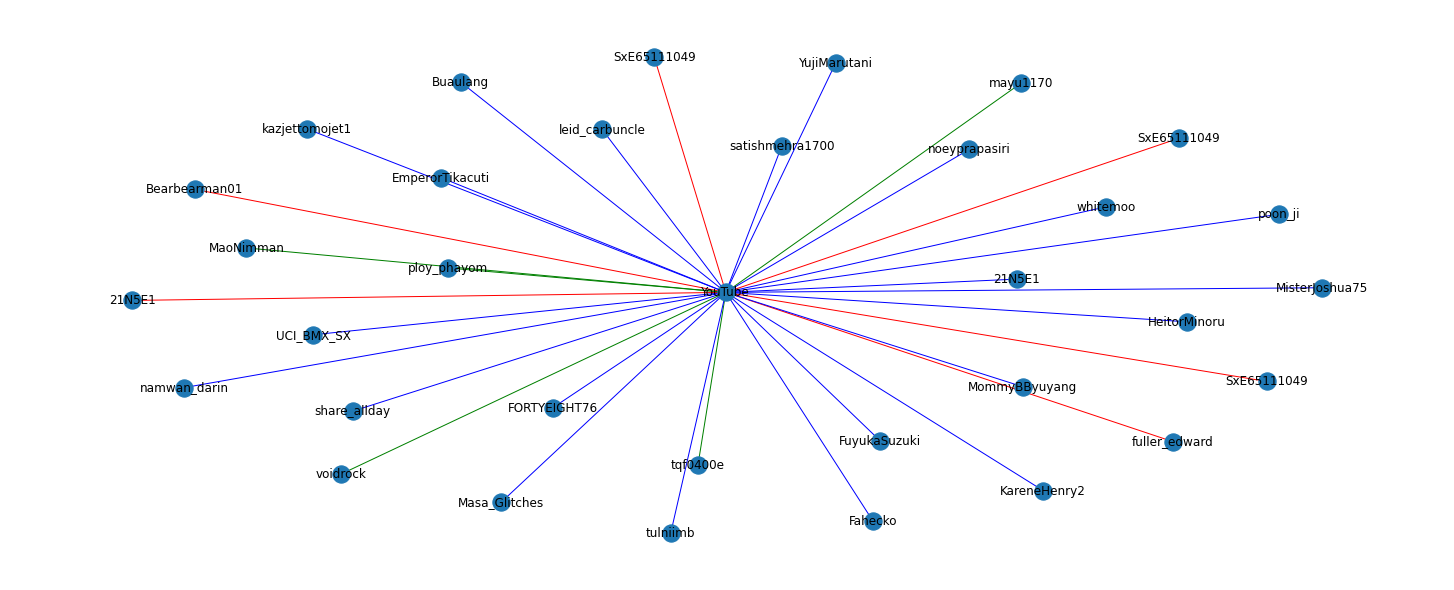

In [ ]:
make_graph(biggest[0])

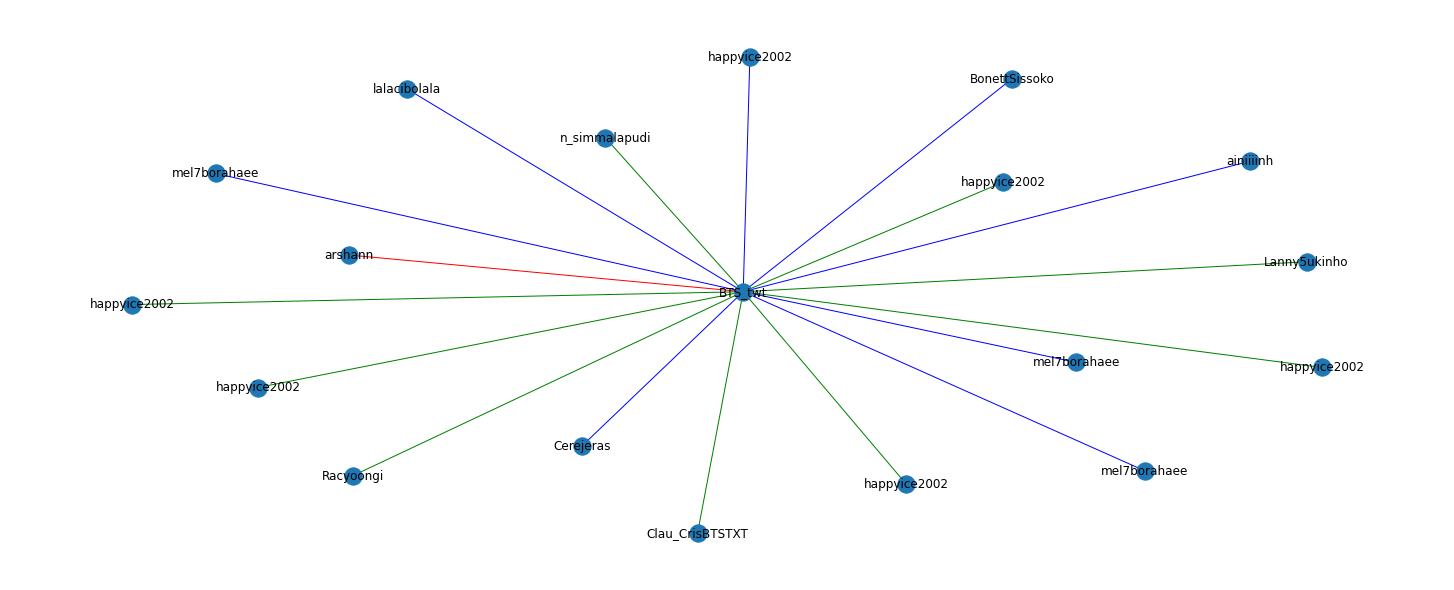

In [ ]:
make_graph(biggest[4])

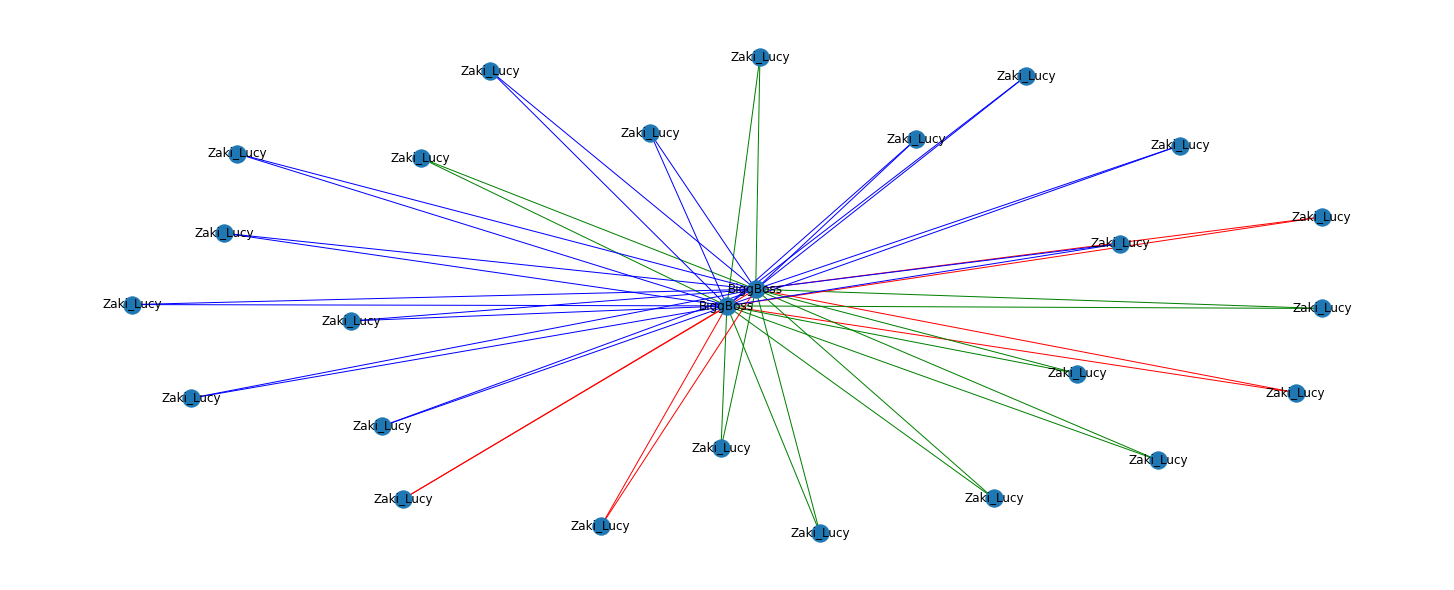

In [ ]:
make_graph(biggest[8])

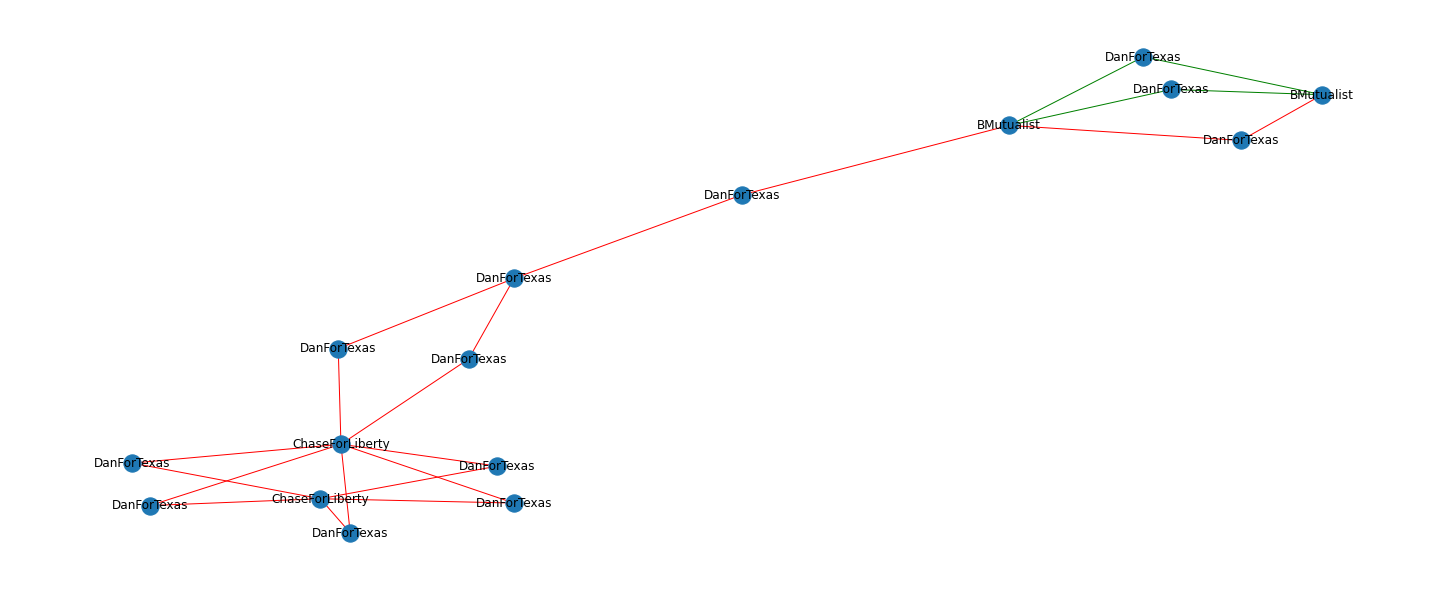

In [ ]:
make_graph(biggest[11])

In [ ]:
edges = biggest[11].edges()
text_list = [graph[u][v]['text'] for u,v in edges]
sent_list = [graph[u][v]['tweet_sent'] for u,v in edges]
for n,i in enumerate(sent_list):
  if i =='Negative':
    print(text_list[n])

@BMutualist @ChaseForLiberty @802libertarian Are there more wage strikes now than there were 2 years ago? Why? Inflation. From covid. It's complicated, and you can lt ever trace any of this back to one thing. That's great for the people who are making shitty decisions and accelerating this.
@BMutualist @ChaseForLiberty @802libertarian Are there more wage strikes now than there were 2 years ago? Why? Inflation. From covid. It's complicated, and you can lt ever trace any of this back to one thing. That's great for the people who are making shitty decisions and accelerating this.
@BMutualist @ChaseForLiberty @802libertarian I hope it never comes to that, but that's the threat. It's just a threat for now. It's up to us to stop it.
@BMutualist @ChaseForLiberty @802libertarian I hope it never comes to that, but that's the threat. It's just a threat for now. It's up to us to stop it.
@ChaseForLiberty @802libertarian @BMutualist China's energy shortage is a ripple effect of politicians in Aust